In [1]:
your_path = "/content/"
try:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir(your_path)
    print(os.getcwd())
except ModuleNotFoundError:
    print("you are not in google colab, pass this phase")
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

Mounted at /content/drive
/content


# Neural Network with MNIST 

## torchvision 패키지

torchvision 은 컴퓨터 비전과 관련된 유틸들을 모아둔 패키지다. 

In [2]:
pwd

'/content'

In [3]:
# 데이터 경로
data_path = "./"

train_dataset = datasets.MNIST(
    root=data_path,
    train=True, 
    transform=transforms.ToTensor(),
    download=True)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64, 
    shuffle=True)

test_dataset = datasets.MNIST(
    root=data_path,
    train=False, 
    transform=transforms.ToTensor(),
    download=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64, 
    shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 214839351.20it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 108934976.46it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 99783453.76it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2538040.07it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



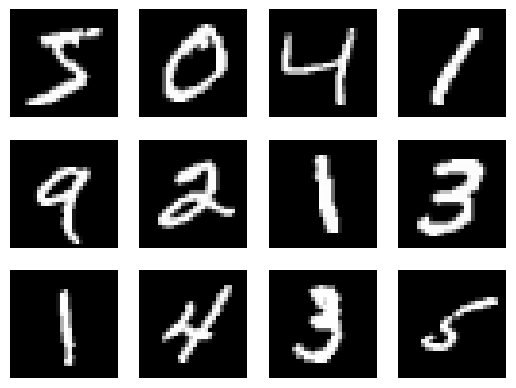

In [4]:
fig, axes = plt.subplots(3, 4)
img_tensors = train_dataset.data[:12]
for ax, img in zip(axes.flatten(), img_tensors):
    ax.imshow(img, cmap="gray")
    ax.axis("off")

## MNIST 모델(Coding Part)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

### **네트워크 설계**

**1. 다음의 구조를 참고하여 Network 클래스를 완성하시오.**

* Input Size = (B, 1, 28, 28)
* Output Size = (B, 10)
* Linear Layer 1(`nn.Linear`): Hidden size = 300  
* Linear Layer 2(`nn.Linear`): Hidden size = 100 
* Activation Function(`nn.ReLU`): ReLU
* Loss Function(`nn.CrossEntropyLoss`): Cross Entropy Loss
* Optimizer(`optim.Adam`): Adam

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # 층을 구성
        """write your code"""
        self.layers = nn.Sequential(
            nn.Linear(1*28*28, 300),  # in_features 28*28, out_features 300
            nn.ReLU(),
            nn.Linear(300,100),
            nn.ReLU(),
            nn.Linear(100,10),
        )

    def forward(self, x):
        # forward propagation 수행
        # x의 차원을 (미니배치, 28*28)에 알맞게 수정한다.
        x = x.view(x.size(0), -1) # 1. 28 28
        """write your code"""
        logits = self.layers(x)
        return logits

### **손실함수 및 옵티마이저**

** 2. loss function과 optimizer를 선택하시오 **


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 커스텀 모듈 호출
model = Network().to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 모델 훈련

훈련 데이터로 모델을 훈련시키고, 테스트 데이터로 최적의 모델을 결정한다.

In [9]:
n_train = len(train_dataset)
n_test = len(test_dataset)
n_step = 10
print_step = 300
best_accuracy = 0

for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}\n [Training Step]")
    # Training
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # 입력과 타겟 텐서에 GPU 를 사용여부 전달
        data, target = data.to(device), target.to(device)
        # 경사 초기화
        model.zero_grad()
        # 순방향 전파
        output = model(data) 
        # 손실값 계산
        loss = loss_function(output,target)
        # 역방향 전파
        loss.backward()
        # 매개변수 업데이트
        optimizer.step()
        # 중간 과정 print
        if batch_idx % print_step == 0:
            percentage = (batch_idx*64 / n_train) * 100
            print(f" - [{percentage:.2f}%] train loss: {loss:.4f}")
            
    # Validation
    model.eval()
    test_loss = 0
    correct = 0
    # torch.no_grad 를 사용하면 requires_grad 를 꺼두게 된다.
    with torch.no_grad():
        for data, target in test_loader:
            # 입력과 타겟 텐서에 GPU 를 사용여부 전달
            data, target = data.to(device), target.to(device)
            # 순방향전파
            output = model(data)
            # 손실값 계산
            test_loss += loss_function(output, target).item()
            # 예측 값에 해당하는 클래스 번호 반환
            pred = output.softmax(1).argmax(dim=1, keepdim=True)
            # 정확하게 예측한 개수를 기록한다
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_accuracy = correct / n_test
    print(f" [Validation Step]")
    print(f" - test loss: {test_loss:.4f} test accuracy: {test_accuracy*100:.2f} %")
    
    # 제일 성능을 보인 좋은 모델 저장하기
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), "best_model-mnist.pt")
    

[Step] 1/10
 [Training Step]
 - [0.00%] train loss: 2.2953
 - [32.00%] train loss: 0.2197
 - [64.00%] train loss: 0.1468
 - [96.00%] train loss: 0.1478
 [Validation Step]
 - test loss: 19.9663 test accuracy: 96.18 %
[Step] 2/10
 [Training Step]
 - [0.00%] train loss: 0.0524
 - [32.00%] train loss: 0.0796
 - [64.00%] train loss: 0.0879
 - [96.00%] train loss: 0.1361
 [Validation Step]
 - test loss: 15.5676 test accuracy: 96.73 %
[Step] 3/10
 [Training Step]
 - [0.00%] train loss: 0.0393
 - [32.00%] train loss: 0.1310
 - [64.00%] train loss: 0.0587
 - [96.00%] train loss: 0.1078
 [Validation Step]
 - test loss: 13.9279 test accuracy: 97.22 %
[Step] 4/10
 [Training Step]
 - [0.00%] train loss: 0.0192
 - [32.00%] train loss: 0.0775
 - [64.00%] train loss: 0.1689
 - [96.00%] train loss: 0.1048
 [Validation Step]
 - test loss: 12.2604 test accuracy: 97.48 %
[Step] 5/10
 [Training Step]
 - [0.00%] train loss: 0.0717
 - [32.00%] train loss: 0.0041
 - [64.00%] train loss: 0.0094
 - [96.00%] tra

## 이미지를 그려보고 테스트 해보자!

In [10]:
load_path = "best_model-mnist.pt"
model = Network()
model.load_state_dict(torch.load(load_path, map_location="cpu"))

def predict(model, x):
    model.eval()
    output = model(x)
    pred = output.argmax(1)
    print(f"Predict Number is {pred.item()}")

In [11]:
try:
    from google.colab.output import eval_js
    from IPython.display import HTML, Image
    from base64 import b64decode
except ModuleNotFoundError:
    print("only support in google colabotory")

In [12]:
canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=480, h=480, line_width=25):
    display(HTML(canvas_html % (w, h, line_width)))
    data = eval_js("data")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    from PIL import Image
    import numpy as np
    img = Image.open(filename)
    img.thumbnail((28, 28), Image.ANTIALIAS)
    x = np.array(img)[:, :, -1]
    img = Image.fromarray(x)
    img.save(filename)
    print(f"'{filename}' image saved!")
    
def load_image(filename="drawing.png"):
    from PIL import Image
    import numpy as np
    import matplotlib.pyplot as plt
    img = Image.open(filename)
    x = np.array(img) / 255.0
    plt.imshow(x)
    plt.show()
    return x[np.newaxis, np.newaxis, :, :]

In [27]:
draw()

'drawing.png' image saved!


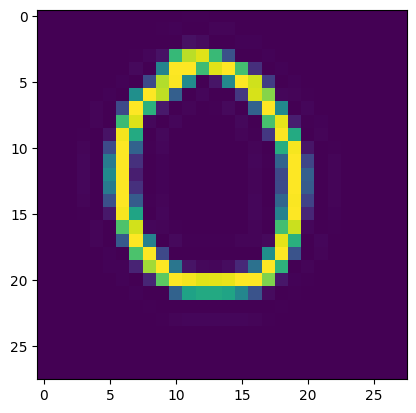

Predict Number is 0


In [28]:
x = load_image()
x = torch.FloatTensor(x)
predict(model, x)